In this notebook, I am playing around with the code required to take an image that is saved in the local Postgres database and utilize it in some way. We know that we will be doing some machine learning to locate the dart board, as well as computer vision tasks in order to locate darts, but I mostly concerned with setting up the framework to simply to the following:

<strong>Take an image from the database ---> display it/ read it ---> generate a fake score for it (something we will do for real later) ---> and save it to an appropriate table. Probably a new table I need to create.</strong> 

In [1]:
# Imports
import psycopg2
from PIL import Image
from io import BytesIO
import base64
import matplotlib.pyplot as plt
from psycopg2 import sql
from scipy.ndimage import rotate
import cv2
import numpy as np
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import io
import base64
from PIL import Image
import psycopg2
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO

### Connect to local postrgres db

In [2]:
# Database connection parameters
hostname = 'localhost'
username = 'dart_thrower'
password = 'darts'
database = 'darts'

try:
    connection = psycopg2.connect(
        host=hostname,
        user=username,
        password=password,
        dbname=database
    )

    print("Connection to the database established successfully.")

    cursor = connection.cursor()

    cursor.execute(sql.SQL("SELECT * FROM games LIMIT 5"))  # Replace `your_table_name` with an actual table name
    records = cursor.fetchall()

    print("Records from the table:")
    for record in records:
        print(record)

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the cursor and connection
    if cursor:
        cursor.close()
    if connection:
        connection.close()

Connection to the database established successfully.
Records from the table:
(1, datetime.datetime(2025, 3, 24, 17, 51, 27, 833086))
(2, datetime.datetime(2025, 3, 24, 17, 54, 6, 198471))
(3, datetime.datetime(2025, 3, 24, 17, 54, 46, 825948))
(4, datetime.datetime(2025, 3, 24, 17, 55, 15, 888245))
(5, datetime.datetime(2025, 3, 24, 17, 59, 22, 982385))


### Displaying an image

Connection to the database established successfully.
Retrieved data type: <class 'str'>


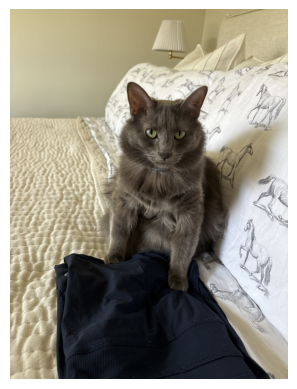

In [3]:
# Database connection parameters
hostname = 'localhost'
username = 'dart_thrower'
password = 'darts'
database = 'darts'

# Connect to the PostgreSQL server
try:
    connection = psycopg2.connect(
        host=hostname,
        user=username,
        password=password,
        dbname=database
    )

    print("Connection to the database established successfully.")

    # Create a cursor object
    cursor = connection.cursor()
    
    # Query to retrieve the image data
    cursor.execute("SELECT image_data FROM images WHERE id = %s", (10,))  # Change the 1 to the ID of your image
    image_data = cursor.fetchone()

    if image_data is not None:
        # Print the type of image_data
        print(f"Retrieved data type: {type(image_data[0])}")

        # Decode the Base64 string into bytes
        image_bytes = base64.b64decode(image_data[0])

        # Create an image from the bytes
        image = Image.open(BytesIO(image_bytes))
        
        # Display the image using matplotlib
        image = rotate(image, angle=270, reshape=True)
        plt.imshow(image)
        plt.axis('off')  # Hide the axis
        plt.show()
    else:
        print("No image found with the specified ID.")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the cursor and connection
    if cursor:
        cursor.close()
    if connection:
        connection.close()


### Sending a processed picture back to the db

Here is where we would theoretically do something to the image. Assuming our image is the dart board with darts thrown at it.. we would do everything required to process that image to get a score out of it.

Since we are not at that point, I will just do a random edit to the image we received, and we can pretend that we did whatever was required to get a score. Therefore, <strong> we will assume here at this point that we are returning a processed dartboard, which can return a score from it. We need to create a new table in our database to do this. </strong>

The below will grab the most recent image captured, display it, process it, and return it to a new table called processed_images

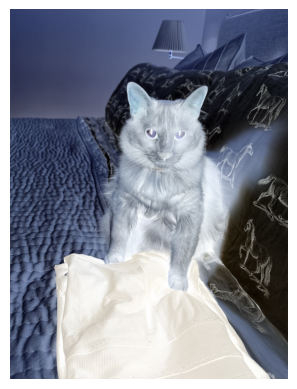

In [4]:
hostname = 'localhost'
username = 'dart_thrower'
password = 'darts'
database = 'darts'

def randomDartScores():
    return np.random.randint(1, 21, size=3)  # Random scores between 1 and 20

def processImage(image): # Here we'll turn the image negative
    negative_image = 255 - image
    return negative_image

def process_latest_image():
    # Connect to the PostgreSQL database
    conn = psycopg2.connect(
        host=hostname,
        user=username,
        password=password,
        dbname=database
    )
    
    cursor = conn.cursor()

    # Step 1: Retrieve the image with the largest ID
    cursor.execute("SELECT id, player_name, game_id, image_data FROM images ORDER BY id DESC LIMIT 1")
    latest_image_record = cursor.fetchone()

    if latest_image_record:
        image_id, player_name, game_id, image_data = latest_image_record
        
        # Decode the Base64 string into bytes if image_data is a string
        image_bytes = base64.b64decode(image_data)

        # Create an image from the bytes
        image = Image.open(io.BytesIO(image_bytes))
        image = np.array(image)  # Convert the Image object to a numpy array

        # Rotate the image 270 degrees
        image = rotate(image, angle=270, reshape=True)

        # Process the image (turning it negative)
        image = processImage(image)

        # Display the processed image using matplotlib
        plt.imshow(image)
        plt.axis('off')  # Hide the axis
        plt.show()

        # Get dart scores and convert them to regular integers
        dart_scores = randomDartScores()
        dart_1, dart_2, dart_3 = map(int, dart_scores)  # Converts each score to a Python int

        # Store the image back as bytes
        processed_image_data = io.BytesIO()
        plt.imsave(processed_image_data, image)  # Save the processed image to a BytesIO object
        processed_image_data.seek(0)  # Seek to the beginning

        # Insert into processed_images table
        cursor.execute('''
            INSERT INTO processed_images (dart_1, dart_2, dart_3, game_id, player_name, processed_image)
            VALUES (%s, %s, %s, %s, %s, %s)
        ''', (dart_1, dart_2, dart_3, game_id, player_name, processed_image_data.getvalue()))

        # Commit the changes
        conn.commit()

    else:
        print("No images found in the database.")

    # Close the database connection
    conn.close()


# Run the function to process the latest image
process_latest_image()


### Retreiving the processed image from processed_images, and displaying the data it has

Connection to the database established successfully.
Retrieved data type: <class 'memoryview'>


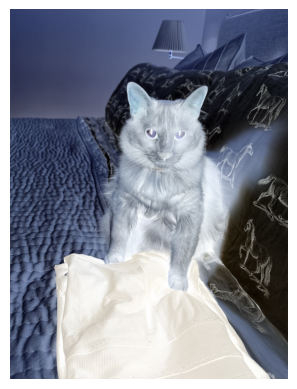

In [5]:
# Database connection parameters
hostname = 'localhost'
username = 'dart_thrower'
password = 'darts'
database = 'darts'

# Connect to the PostgreSQL server
try:
    connection = psycopg2.connect(
        host=hostname,
        user=username,
        password=password,
        dbname=database
    )

    print("Connection to the database established successfully.")

    # Create a cursor object
    cursor = connection.cursor()
    
    # Query to retrieve the image data
    cursor.execute("SELECT processed_image FROM processed_images WHERE id = %s", (1,))  # Change the 1 to the ID of your image
    image_data = cursor.fetchone()

    if image_data is not None:
        # Print the type of image_data
        print(f"Retrieved data type: {type(image_data[0])}")

        # Create an image from the bytes (no decoding necessary)
        image = Image.open(BytesIO(image_data[0]))  # Use image_data[0] directly
        
        # Display the image using matplotlib
        plt.imshow(image)
        plt.axis('off')  # Hide the axis
        plt.show()
    else:
        print("No image found with the specified ID.")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the cursor and connection
    if cursor:
        cursor.close()
    if connection:
        connection.close()


In [6]:
import psycopg2

# Database connection parameters
hostname = 'localhost'
username = 'dart_thrower'
password = 'darts'
database = 'darts'

# Connect to the PostgreSQL server
try:
    connection = psycopg2.connect(
        host=hostname,
        user=username,
        password=password,
        dbname=database
    )

    print("Connection to the database established successfully.")

    # Create a cursor object
    cursor = connection.cursor()
    
    # Query to retrieve all columns for the row where id = 1
    cursor.execute("SELECT * FROM processed_images WHERE id = %s", (1,))
    row = cursor.fetchone()  # Fetch the first row of results

    if row is not None:
        # Print all columns in the retrieved row
        column_names = [desc[0] for desc in cursor.description]
        for column_name, value in zip(column_names, row):
            print(f"{column_name}: {value}")
    else:
        print("No row found with the specified ID.")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the cursor and connection
    if cursor:
        cursor.close()
    if connection:
        connection.close()


Connection to the database established successfully.
id: 1
dart_1: 1
dart_2: 17
dart_3: 1
game_id: 34
player_name: Reed
processed_image: <memory at 0x70b45ac18700>


So now, we can read and write images to our database. We will just need to figure out a scoring function, and flesh out the front end. Add in some "cricket" game logic and we are complete. 

### Messing around with a sample photo

In [7]:
#!pip install opencv-python numpy tensorflow

All I did in the below was create a function that will grab template photos from an image of the board for the 20 and the 3. We can can use some geometry to get the rest of the board.

You could also just screenshot the 20 and the 3 from the larger photo.

In [8]:
def create_template(image_path, output_20_path, output_3_path):
    # Load the dartboard image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Image not found.")
        return

    # Define the coordinates for cropping the numbers
    # You may need to adjust these coordinates based on your image
    # Format: (start_x, start_y, width, height)
    coords_20 = (2051,1864,70,70)  # Example coordinates for "20"
    coords_3 = (2066,2635,50,60)   # Example coordinates for "3"

    # Crop the "20" number
    x, y, w, h = coords_20
    template_20 = image[y:y+h, x:x+w]
    cv2.imwrite(output_20_path, template_20)
    print(f"Template for '20' saved to {output_20_path}")

    # Crop the "3" number
    x, y, w, h = coords_3
    template_3 = image[y:y+h, x:x+w]
    cv2.imwrite(output_3_path, template_3)
    print(f"Template for '3' saved to {output_3_path}")

# Only need to do this once to get the intial templates
# create_template(
#     '/home/tars/Projects/Dart-Vision/Sample Images/throw_1_1.JPG',
#     '/home/tars/Projects/Dart-Vision/Templates/20_cropped.png',
#     '/home/tars/Projects/Dart-Vision/Templates/3_cropped.png'
# )


Now, in the below code, we take in the image of our darts that were thrown.. an output path, and our two templates.

The result is a cropped image of the board. 

The next step would be to get this in a workflow such that we are able to pull the most recently captured photo when a user saves a photo from the front end. For now, I am less worried about the logistics of that and more worried about quantifying the board for scoring. 

<strong> One notable shortcoming of this method is that the template for the 20 and the 3 do not currently work for 20's and 3's at different scales. Therefore, if a user zoomed in and took their photo, the board would not be detected correctly. I tested this with the sample photos, and all the photos I took from where I threw the darts worked perfectly fine, despite me not being super careful about where I took the photo from. </strong>

In [29]:
def detect_numbers_and_crop(image_path, output_path, template_20_path, template_3_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Image not found.")
        return

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Load templates for "20" and "3"
    template_20 = cv2.imread(template_20_path, cv2.IMREAD_GRAYSCALE)
    template_3 = cv2.imread(template_3_path, cv2.IMREAD_GRAYSCALE)

    # Perform template matching for 20
    res_20 = cv2.matchTemplate(gray, template_20, cv2.TM_CCOEFF_NORMED)
    threshold_20 = 0.8  # Adjust this threshold as needed
    loc_20 = np.where(res_20 >= threshold_20)

    # Perform template matching for 3
    res_3 = cv2.matchTemplate(gray, template_3, cv2.TM_CCOEFF_NORMED)
    threshold_3 = 0.8  # Adjust this threshold as needed
    loc_3 = np.where(res_3 >= threshold_3)

    print(loc_20[0].size, loc_3[0].size)

    # Check if both numbers were found
    if loc_20[0].size == 0 or loc_3[0].size == 0:
        print("Could not find both numbers on the dartboard.")
        return

    # Get the coordinates of the detected numbers
    top_left_20 = (loc_20[1][0], loc_20[0][0])
    top_left_3 = (loc_3[1][0], loc_3[0][0])

    # Calculate the bottom-left corner of 3
    bottom_left_3 = (top_left_3[0], top_left_3[1] + template_3.shape[0])

    # Calculate the top-right corner of 20
    top_right_20 = (top_left_20[0] + template_20.shape[1], top_left_20[1])

    # Calculate the center and radius of the circle
    center_x = (bottom_left_3[0] + top_right_20[0]) // 2
    center_y = (bottom_left_3[1] + top_left_20[1]) // 2
    radius = int(np.linalg.norm(np.array(bottom_left_3) - np.array(top_right_20)) // 2)

    # Calculate the bounding box for cropping
    x1 = center_x - radius
    y1 = center_y - radius
    x2 = center_x + radius
    y2 = center_y + radius

    # Ensure the coordinates are within the image boundaries
    x1 = max(x1, 0)
    y1 = max(y1, 0)
    x2 = min(x2, image.shape[1])
    y2 = min(y2, image.shape[0])

    # Crop the image
    cropped_image = image[y1:y2, x1:x2]

    # Save the cropped image
    cv2.imwrite(output_path, cropped_image)
    print(f"Cropped image saved to {output_path}")

In [48]:
import cv2
import numpy as np

def generate_scaled_templates(template, scales):
    """Generate scaled versions of the template."""
    scaled_templates = []
    for scale in scales:
        # Resize the template
        new_size = (int(template.shape[1] * scale), int(template.shape[0] * scale))
        scaled_template = cv2.resize(template, new_size, interpolation=cv2.INTER_LINEAR)
        scaled_templates.append(scaled_template)
    return scaled_templates

def detect_numbers_and_crop(image_path, output_path, template_20_path, template_3_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Image not found.")
        return

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Load templates for "20" and "3"
    template_20 = cv2.imread(template_20_path, cv2.IMREAD_GRAYSCALE)
    template_3 = cv2.imread(template_3_path, cv2.IMREAD_GRAYSCALE)

    # Generate scaled templates
    scales = [0.9 + 0.01 * i for i in range(-10, 11)]  # 10 smaller and 10 larger
    scaled_templates_20 = generate_scaled_templates(template_20, scales)
    scaled_templates_3 = generate_scaled_templates(template_3, scales)

    loc_20 = []
    loc_3 = []

    # Perform template matching for each scaled template
    for scaled_template in scaled_templates_20:
        res_20 = cv2.matchTemplate(gray, scaled_template, cv2.TM_CCOEFF_NORMED)
        threshold_20 = 0.8  # Adjust this threshold as needed
        loc_20_level = np.where(res_20 >= threshold_20)
        loc_20.extend(zip(loc_20_level[1], loc_20_level[0]))  # Store (x, y) coordinates

    for scaled_template in scaled_templates_3:
        res_3 = cv2.matchTemplate(gray, scaled_template, cv2.TM_CCOEFF_NORMED)
        threshold_3 = 0.8  # Adjust this threshold as needed
        loc_3_level = np.where(res_3 >= threshold_3)
        loc_3.extend(zip(loc_3_level[1], loc_3_level[0]))  # Store (x, y) coordinates

    print(len(loc_20), len(loc_3))

    # Check if both numbers were found
    if not loc_20 or not loc_3:
        print("Could not find both numbers on the dartboard.")
        return

    # Get the coordinates of the first detected numbers
    top_left_20 = loc_20[0]
    top_left_3 = loc_3[0]

    # Calculate the bottom-left corner of 3
    bottom_left_3 = (top_left_3[0], top_left_3[1] + template_3.shape[0])

    # Calculate the top-right corner of 20
    top_right_20 = (top_left_20[0] + template_20.shape[1], top_left_20[1])

    # Calculate the center and radius of the circle
    center_x = (bottom_left_3[0] + top_right_20[0]) // 2
    center_y = (bottom_left_3[1] + top_left_20[1]) // 2
    radius = int(np.linalg.norm(np.array(bottom_left_3) - np.array(top_right_20)) // 2)

    # Calculate the bounding box for cropping
    x1 = center_x - radius
    y1 = center_y - radius
    x2 = center_x + radius
    y2 = center_y + radius

    # Ensure the coordinates are within the image boundaries
    x1 = max(x1, 0)
    y1 = max(y1, 0)
    x2 = min(x2, image.shape[1])
    y2 = min(y2, image.shape[0])

    # Crop the image
    cropped_image = image[y1:y2, x1:x2]

    # Save the cropped image
    cv2.imwrite(output_path, cropped_image)
    print(f"Cropped image saved to {output_path}")

In [101]:
# get the cropped dartboard of thrown darts
detect_numbers_and_crop(
    '/home/tars/Projects/Dart-Vision/Sample Images/throw_5_1.JPG',
    '/home/tars/Projects/Dart-Vision/Sample Images/thrown_dartboard.JPG',
    '/home/tars/Projects/Dart-Vision/Templates/20_cropped.png',  # Path to "20" template
    '/home/tars/Projects/Dart-Vision/Templates/3_cropped.png'    # Path to "3" template
)

32 21
Cropped image saved to /home/tars/Projects/Dart-Vision/Sample Images/thrown_dartboard.JPG


In [102]:
# get the cropped dartboard of no darts thrown for comparison
detect_numbers_and_crop(
    '/home/tars/Projects/Dart-Vision/Sample Images/blank_dartboard.JPG',
    '/home/tars/Projects/Dart-Vision/Sample Images/blank_dartboard_cropped.JPG',
    '/home/tars/Projects/Dart-Vision/Templates/20_cropped.png',  # Path to "20" template
    '/home/tars/Projects/Dart-Vision/Templates/3_cropped.png'    # Path to "3" template
)

39 80
Cropped image saved to /home/tars/Projects/Dart-Vision/Sample Images/blank_dartboard_cropped.JPG


In [103]:
# image = cv2.imread('/home/tars/Projects/Dart-Vision/Sample Images/thrown_dartboard.JPG')
# image.shape

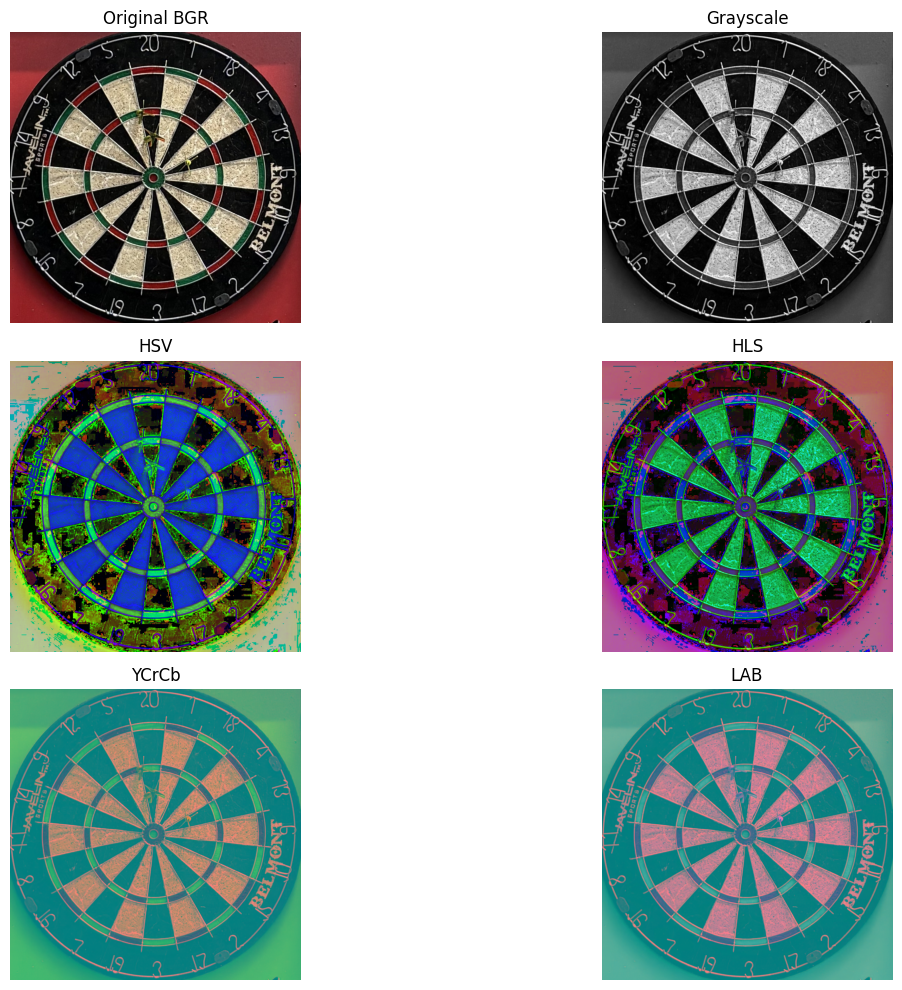

In [104]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_color_spaces(image_path):
    # Load the cropped dartboard image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Image not found.")
        return

    # Convert to different color spaces
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hls_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    ycrcb_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)

    # Set up the matplotlib figure
    plt.figure(figsize=(15, 10))

    # Display Original BGR Image
    plt.subplot(3, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title('Original BGR')
    plt.axis('off')

    # Display Grayscale Image
    plt.subplot(3, 2, 2)
    plt.imshow(gray_image, cmap='gray')
    plt.title('Grayscale')
    plt.axis('off')

    # Display HSV Image
    plt.subplot(3, 2, 3)
    plt.imshow(hsv_image)
    plt.title('HSV')
    plt.axis('off')

    # Display HLS Image
    plt.subplot(3, 2, 4)
    plt.imshow(hls_image)
    plt.title('HLS')
    plt.axis('off')

    # Display YCrCb Image
    plt.subplot(3, 2, 5)
    plt.imshow(ycrcb_image)
    plt.title('YCrCb')
    plt.axis('off')

    # Display LAB Image
    plt.subplot(3, 2, 6)
    plt.imshow(lab_image)
    plt.title('LAB')
    plt.axis('off')

    # Show the plots
    plt.tight_layout()
    plt.show()

# Example usage
visualize_color_spaces('/home/tars/Projects/Dart-Vision/Sample Images/thrown_dartboard.JPG')


In [107]:
def resize_images(img1, img2):
    # Resize img2 to match img1 if they are not the same size
    if img1.shape != img2.shape:
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]), interpolation=cv2.INTER_AREA)
    return img1, img2

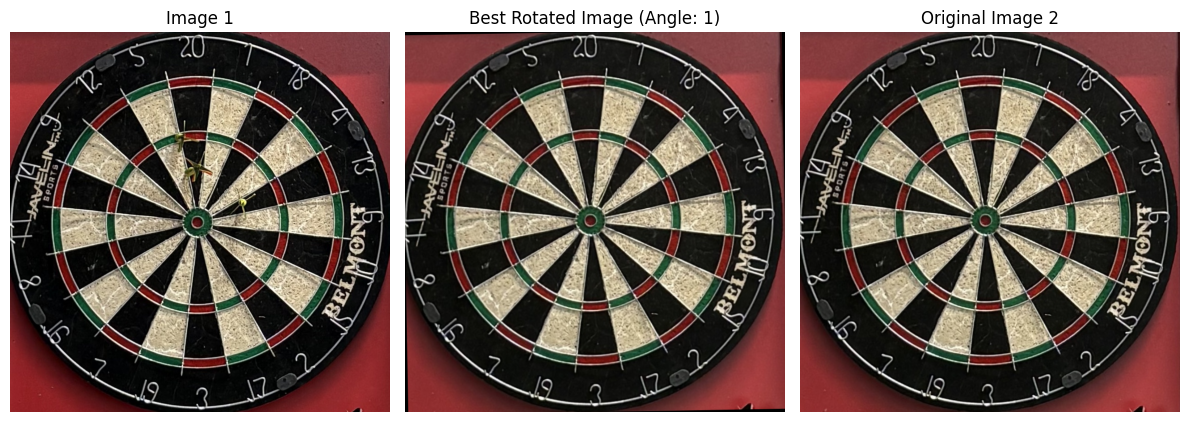

In [108]:
def load_images(image_path1, image_path2):
    # Load the images
    img1 = cv2.imread(image_path1)
    img2 = cv2.imread(image_path2)

    if img1 is None or img2 is None:
        raise ValueError("One of the images could not be loaded.")

    return img1, img2

def rotate_image(image, angle):
    # Get the image dimensions
    (h, w) = image.shape[:2]
    # Calculate the center of the image
    center = (w // 2, h // 2)
    # Perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

def calculate_mse(img1, img2):
    # Calculate Mean Squared Error between two images
    return np.mean((img1.astype(np.float32) - img2.astype(np.float32)) ** 2)

def find_best_rotation(img1, img2, angle_range=(-10, 10), step=1):
    best_angle = 0
    min_mse = float('inf')
    best_rotated_img = img2

    # Iterate over the specified range of angles
    for angle in range(angle_range[0], angle_range[1] + 1, step):
        rotated_img = rotate_image(img2, angle)
        mse = calculate_mse(img1, rotated_img)

        if mse < min_mse:
            min_mse = mse
            best_angle = angle
            best_rotated_img = rotated_img

    return best_angle, best_rotated_img

def visualize_results(img1, img2, best_rotated_img, best_angle):
    # Plot the images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title('Image 1')
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Best Rotated Image (Angle: {})'.format(best_angle))
    plt.imshow(cv2.cvtColor(best_rotated_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Original Image 2')
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def main():
    image_path1 = '/home/tars/Projects/Dart-Vision/Sample Images/thrown_dartboard.JPG'
    image_path2 = '/home/tars/Projects/Dart-Vision/Sample Images/blank_dartboard_cropped.JPG'

    img1, img2 = load_images(image_path1, image_path2)
    img1, img2 = resize_images(img1, img2)
    best_angle, best_rotated_img = find_best_rotation(img1, img2, angle_range=(-10, 10), step=1)

    # Save the rotated image with "_rotated" appended to the filename
    rotated_image_path = image_path2.replace('.JPG', '_rotated.JPG')
    cv2.imwrite(rotated_image_path, best_rotated_img)

    visualize_results(img1, img2, best_rotated_img, best_angle)

if __name__ == "__main__":
    main()


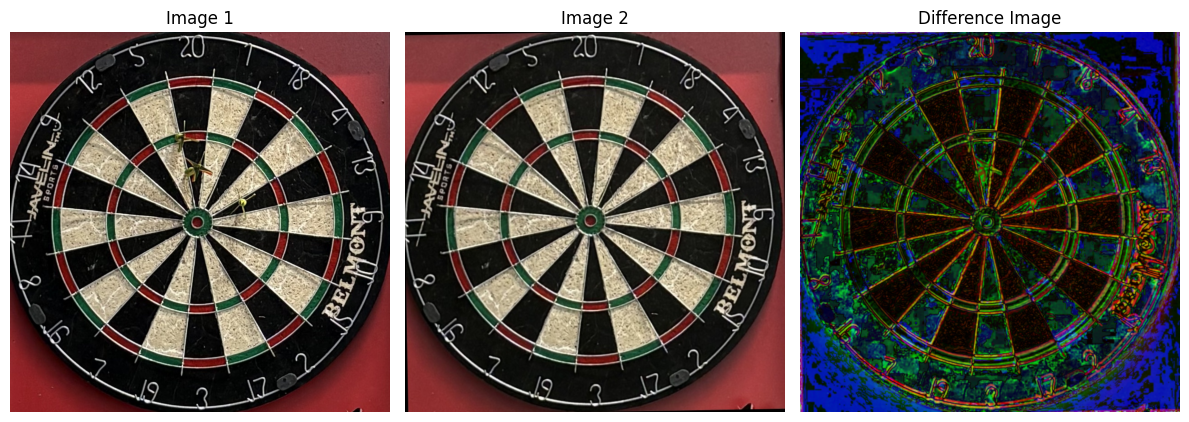

In [109]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_images(image_path1, image_path2):
    # Load the images
    img1 = cv2.imread(image_path1)
    img2 = cv2.imread(image_path2)

    if img1 is None or img2 is None:
        raise ValueError("One of the images could not be loaded.")

    return img1, img2



def compare_images(img1, img2):
    # Check if images are identical
    if np.array_equal(img1, img2):
        print("The images are identical.")
        return None, []

    # Convert to HSV color space
    img1_hsv = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)
    img2_hsv = cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)

    # Apply Gaussian blur to smooth the images
    img1_blurred = cv2.GaussianBlur(img1_hsv, (5, 5), 0)
    img2_blurred = cv2.GaussianBlur(img2_hsv, (5, 5), 0)

    # Calculate the absolute difference in the processed images
    diff = cv2.absdiff(img1_blurred, img2_blurred)
    diff_gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)

    # Threshold the difference image
    _, thresh = cv2.threshold(diff_gray, 30, 255, cv2.THRESH_BINARY)

    # Find contours of the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours by area
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)

    return diff, sorted_contours[:100]  # Return the top 100 contours

def visualize_differences(img1, img2, diff, contours):
    # Create a copy of the original image to draw on
    img1_copy = img1.copy()

    # Draw rectangles around the top 100 contours
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(img1_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Plot the images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title('Image 1')
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Image 2')
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Difference Image')
    plt.imshow(cv2.cvtColor(diff, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def main():
    image_path1 = '/home/tars/Projects/Dart-Vision/Sample Images/thrown_dartboard.JPG'
    image_path2 = '/home/tars/Projects/Dart-Vision/Sample Images/blank_dartboard_cropped_rotated.JPG'

    img1, img2 = load_images(image_path1, image_path2)
    img1, img2 = resize_images(img1, img2)  # Ensure both images are the same size
    diff, contours = compare_images(img1, img2)
    
    if diff is not None:
        visualize_differences(img1, img2, diff, contours)

if __name__ == "__main__":
    main()

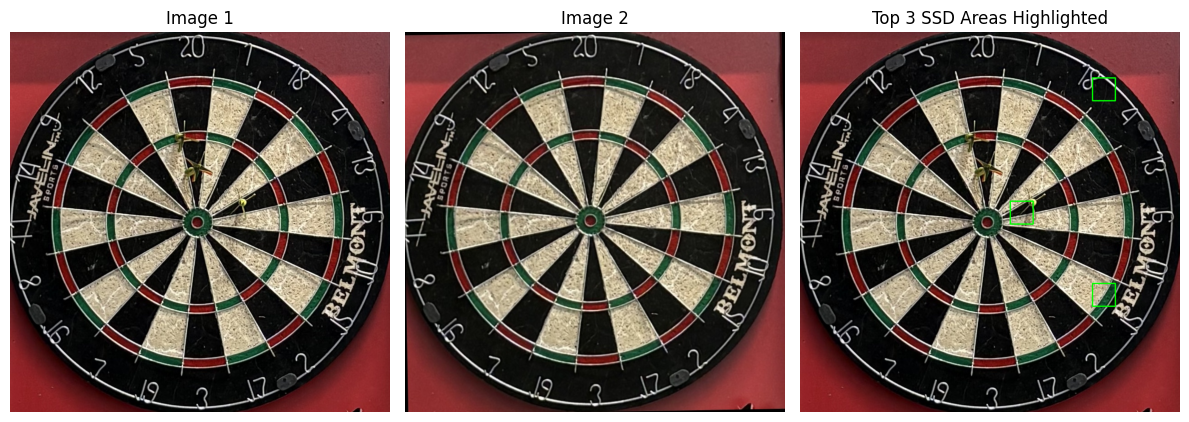

In [110]:
# original attempt: issue is that the orientation is showing differences that are not really there..

def load_images(image_path1, image_path2):
    # Load the images
    img1 = cv2.imread(image_path1)
    img2 = cv2.imread(image_path2)

    if img1 is None or img2 is None:
        raise ValueError("One of the images could not be loaded.")

    return img1, img2

def resize_images(img1, img2):
    # Resize img2 to match img1 if they are not the same size
    if img1.shape != img2.shape:
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]), interpolation=cv2.INTER_AREA)
    return img1, img2

def calculate_ssd_blocks(img1, img2, block_size=50, margin=100):
    height, width = img1.shape[:2]
    ssd_values = []

    # Define the search area limits
    y_start = margin
    y_end = height - margin
    x_start = margin
    x_end = width - margin

    # Iterate through the image in blocks within the defined limits
    for y in range(y_start, y_end - block_size + 1, block_size):
        for x in range(x_start, x_end - block_size + 1, block_size):
            # Extract the blocks
            block1 = img1[y:y + block_size, x:x + block_size]
            block2 = img2[y:y + block_size, x:x + block_size]
            # Calculate the SSD for the block
            ssd = np.sum((block1.astype(np.float32) - block2.astype(np.float32)) ** 2)
            ssd_values.append((ssd, (x, y)))

    # Sort by SSD and return the top 3
    ssd_values.sort(reverse=True, key=lambda x: x[0])
    return ssd_values[:3]

def visualize_differences(img1, img2, top_blocks):
    # Create a copy of the original image to draw on
    img1_copy = img1.copy()

    # Draw rectangles around the top 3 blocks with the highest SSD
    for _, (x, y) in top_blocks:
        cv2.rectangle(img1_copy, (x, y), (x + 50, y + 50), (0, 255, 0), 2)

    # Plot the images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title('Image 1')
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Image 2')
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Top 3 SSD Areas Highlighted')
    plt.imshow(cv2.cvtColor(img1_copy, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def main():
    image_path1 = '/home/tars/Projects/Dart-Vision/Sample Images/thrown_dartboard.JPG'
    image_path2 = '/home/tars/Projects/Dart-Vision/Sample Images/blank_dartboard_cropped_rotated.JPG'

    img1, img2 = load_images(image_path1, image_path2)
    img1, img2 = resize_images(img1, img2)  # Ensure both images are the same size
    top_blocks = calculate_ssd_blocks(img1, img2, block_size=90, margin=100)

    visualize_differences(img1, img2, top_blocks)

if __name__ == "__main__":
    main()

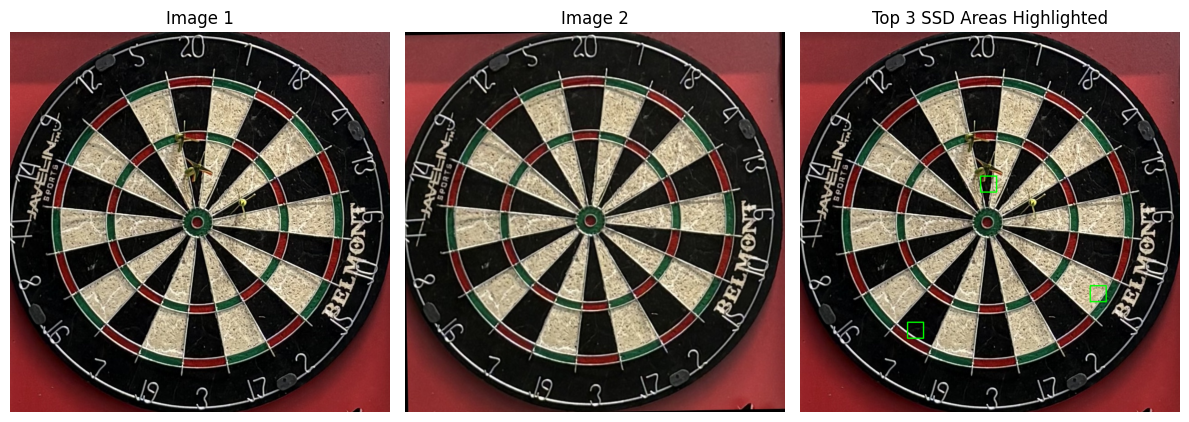

In [111]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_images(image_path1, image_path2):
    # Load the images
    img1 = cv2.imread(image_path1)
    img2 = cv2.imread(image_path2)

    if img1 is None or img2 is None:
        raise ValueError("One of the images could not be loaded.")

    return img1, img2

def resize_images(img1, img2):
    # Resize img2 to match img1 if they are not the same size
    if img1.shape != img2.shape:
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]), interpolation=cv2.INTER_AREA)
    return img1, img2

def calculate_ssd_blocks(img1, img2, block_size=35, margin=75):
    height, width = img1.shape[:2]
    ssd_values = []

    # Define the search area limits
    y_start = margin
    y_end = height - margin
    x_start = margin
    x_end = width - margin

    # Iterate through the image in blocks within the defined limits
    for y in range(y_start, y_end - block_size + 1, block_size - 10):  # Overlap by 10 pixels
        for x in range(x_start, x_end - block_size + 1, block_size - 10):  # Overlap by 10 pixels
            # Extract the blocks
            block1 = img1[y:y + block_size, x:x + block_size]
            block2 = img2[y:y + block_size, x:x + block_size]
            # Calculate the SSD for the block
            ssd = np.sum((block1.astype(np.float32) - block2.astype(np.float32)) ** 2)
            ssd_values.append((ssd, (x, y)))

    # Sort by SSD and return the top 3
    ssd_values.sort(reverse=True, key=lambda x: x[0])
    return ssd_values[:3]

def visualize_differences(img1, img2, top_blocks):
    # Create a copy of the original image to draw on
    img1_copy = img1.copy()

    # Draw rectangles around the top 3 blocks with the highest SSD
    for _, (x, y) in top_blocks:
        cv2.rectangle(img1_copy, (x, y), (x + 35, y + 35), (0, 255, 0), 2)

    # Plot the images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title('Image 1')
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Image 2')
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Top 3 SSD Areas Highlighted')
    plt.imshow(cv2.cvtColor(img1_copy, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def main():
    image_path1 = '/home/tars/Projects/Dart-Vision/Sample Images/thrown_dartboard.JPG'
    image_path2 = '/home/tars/Projects/Dart-Vision/Sample Images/blank_dartboard_cropped_rotated.JPG'

    img1, img2 = load_images(image_path1, image_path2)
    img1, img2 = resize_images(img1, img2)  # Ensure both images are the same size
    top_blocks = calculate_ssd_blocks(img1, img2, block_size=90, margin=75)

    visualize_differences(img1, img2, top_blocks)

if __name__ == "__main__":
    main()
